In [1]:
!wget https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_raw_feature_bc_matrix.h5

--2024-05-31 08:32:10--  https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_raw_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69980835 (67M) [binary/octet-stream]
Saving to: ‘CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_raw_feature_bc_matrix.h5’

CytAssist_FFPE_Prot 100%[===================>]  66.74M   234MB/s    in 0.3s    

2024-05-31 08:32:11 (234 MB/s) - ‘CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_raw_feature_bc_matrix.h5’ saved [69980835/69980835]



In [2]:
path_h5 = "/content/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_raw_feature_bc_matrix.h5"

In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import leidenalg
import igraph as ig


In [4]:
import scanpy.external as sce

In [5]:
adata = sc.read_10x_h5(path_h5)

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
adata.var_names_make_unique()

In [ ]:
adata.obs_names

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['AACAATCCGAGTGGAC-1', 'AACAATGGAACCACAT-1', 'AACAATGTGCTCCGAG-1',
       'AACAATTATCTGCGCC-1', 'AACACCAGCCTACTCG-1', 'AACACCATACGATAGT-1',
       'AACACCATTCGCATAC-1', 'AACACCGAATGTCTCA-1', 'AACACCGAGCTTGGAT-1',
       'AACACCTAAGCATTGC-1',
       ...
       'TGTTGGATAGATCAGA-1', 'TGTTGGCCAATATGGC-1', 'TGTTGGCCGGATTGGT-1',
       'TGTTGGCCTGTAGCGG-1', 'TGTTGGTGAGCGGACG-1', 'TGTTGGTGATTAGGTA-1',
       'TGTTGGTGCGCACGAG-1', 'TGTTGGTGCGCTTCGC-1', 'TGTTGGTGCGGAATCA-1',
       'TGTTGGTGGACTCAGG-1'],
      dtype='object', length=14336)

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

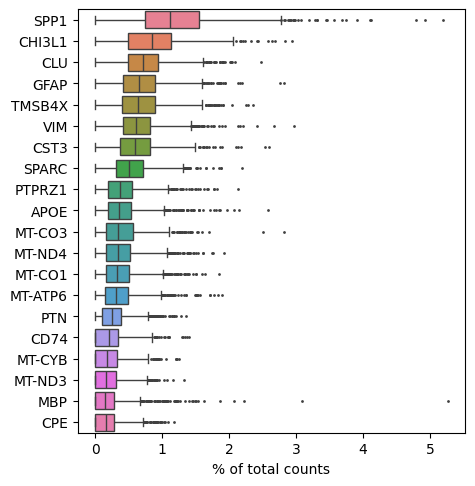

In [12]:
sc.pl.highest_expr_genes(adata, n_top = 20)

In [9]:
# annotate the group of mitochondrial genes as "mt"

adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
 adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

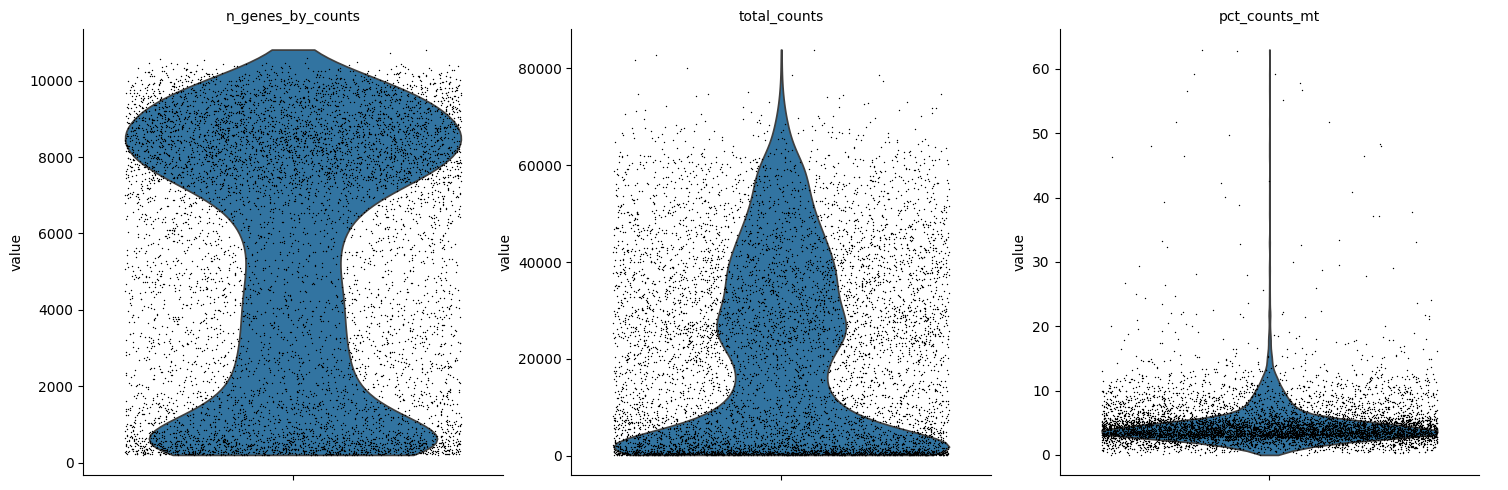

In [10]:
sc.pl.violin(
 adata,
 ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
 jitter=0.4,
 multi_panel=True,
)

In [11]:
# filtering ..

adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [13]:
# Total-count normalize (library-size correct) the data matrix
# to 10,000 reads per cell, so that counts become comparable among cells.

sc.pp.normalize_total(adata, target_sum=1e4)

In [14]:
# Log. the data:

sc.pp.log1p(adata)

In [15]:
# Identifying highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0)

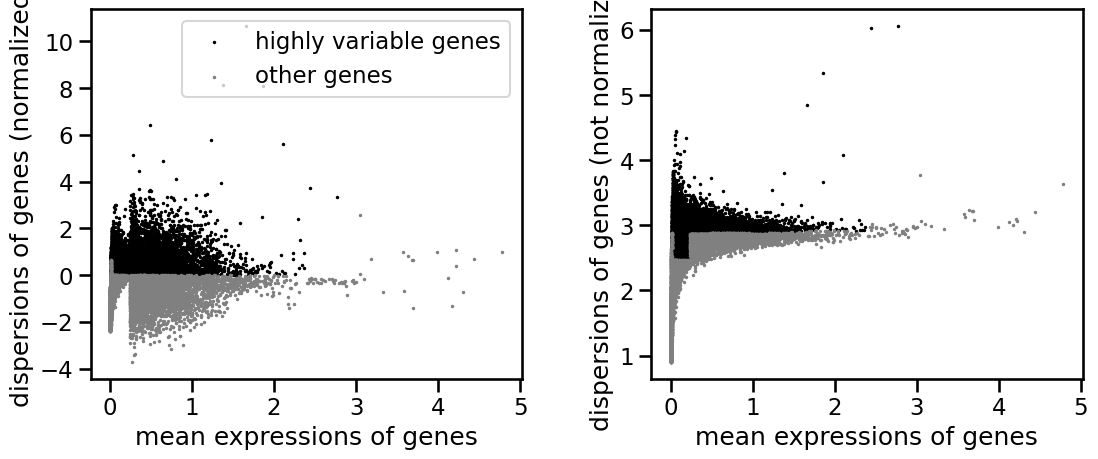

In [ ]:
#plot them
sc.pl.highly_variable_genes(adata)

In [16]:
# more filtering..
adata = adata[:, adata.var.highly_variable]

# Regress out effects of total counts per cell and the % of mit. genes expr
# Scaling then the data to unit variance.
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [17]:
# so, scaling data and clipping values exceeding standard deviation 10

sc.pp.scale(adata, max_value=10)

In [18]:
## PCA
sc.tl.pca(adata, svd_solver="arpack")

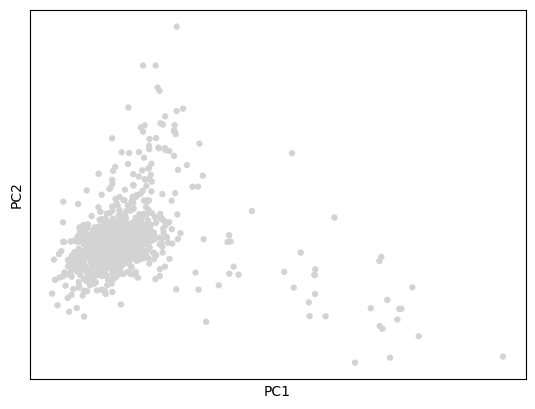

In [19]:
sc.pl.pca(adata)

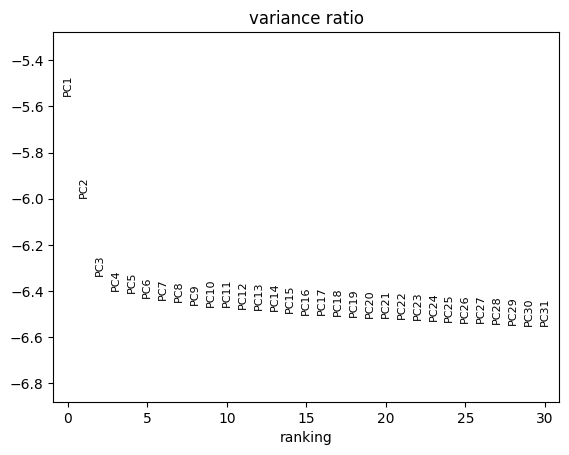

In [20]:
sc.pl.pca_variance_ratio(adata, log=True)

In [22]:

sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_pca')

sc.tl.leiden(adata, resolution=1.0, random_state=0, flavor='igraph', n_iterations=2, directed=False)



In [23]:
#UMAP for visualization

sc.tl.umap(adata)

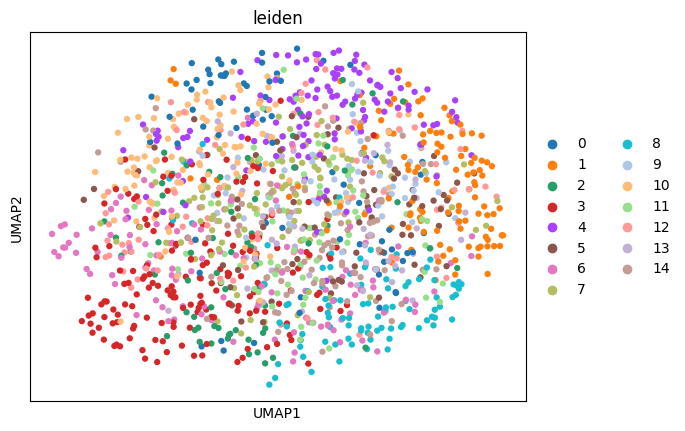

In [24]:


sc.pl.umap(adata, color=['leiden'])


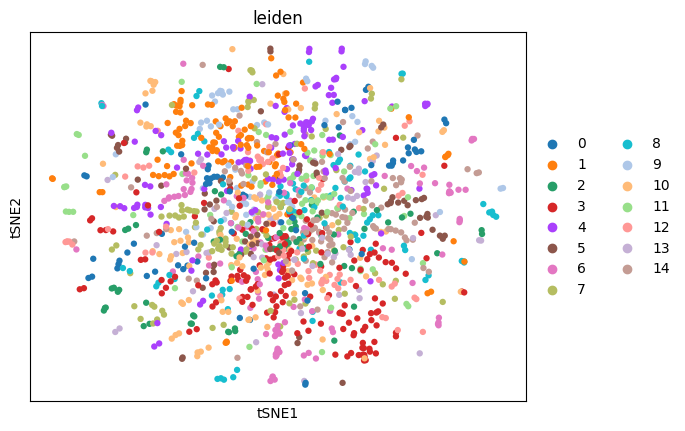

In [25]:

# t-SNE for visualization
sc.tl.tsne(adata)

# Plot the t-SNE results
sc.pl.tsne(adata, color=['leiden'])  # or 'louvain'

leiden
3     169
4     126
1     120
6     118
10    114
7     107
14    100
8      91
11     80
12     78
0      74
5      73
2      70
9      61
13     56
Name: count, dtype: int64


<Axes: xlabel='leiden'>

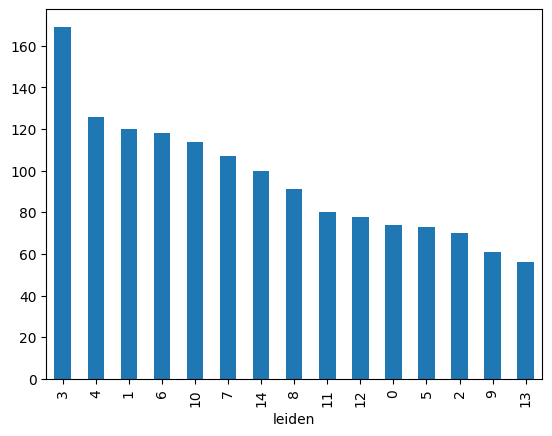

In [26]:


# Check the number of cells in each cluster
cluster_counts = adata.obs['leiden'].value_counts()
print(cluster_counts)

# Visualize cluster composition using a bar plot
cluster_counts.plot.bar()


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: 

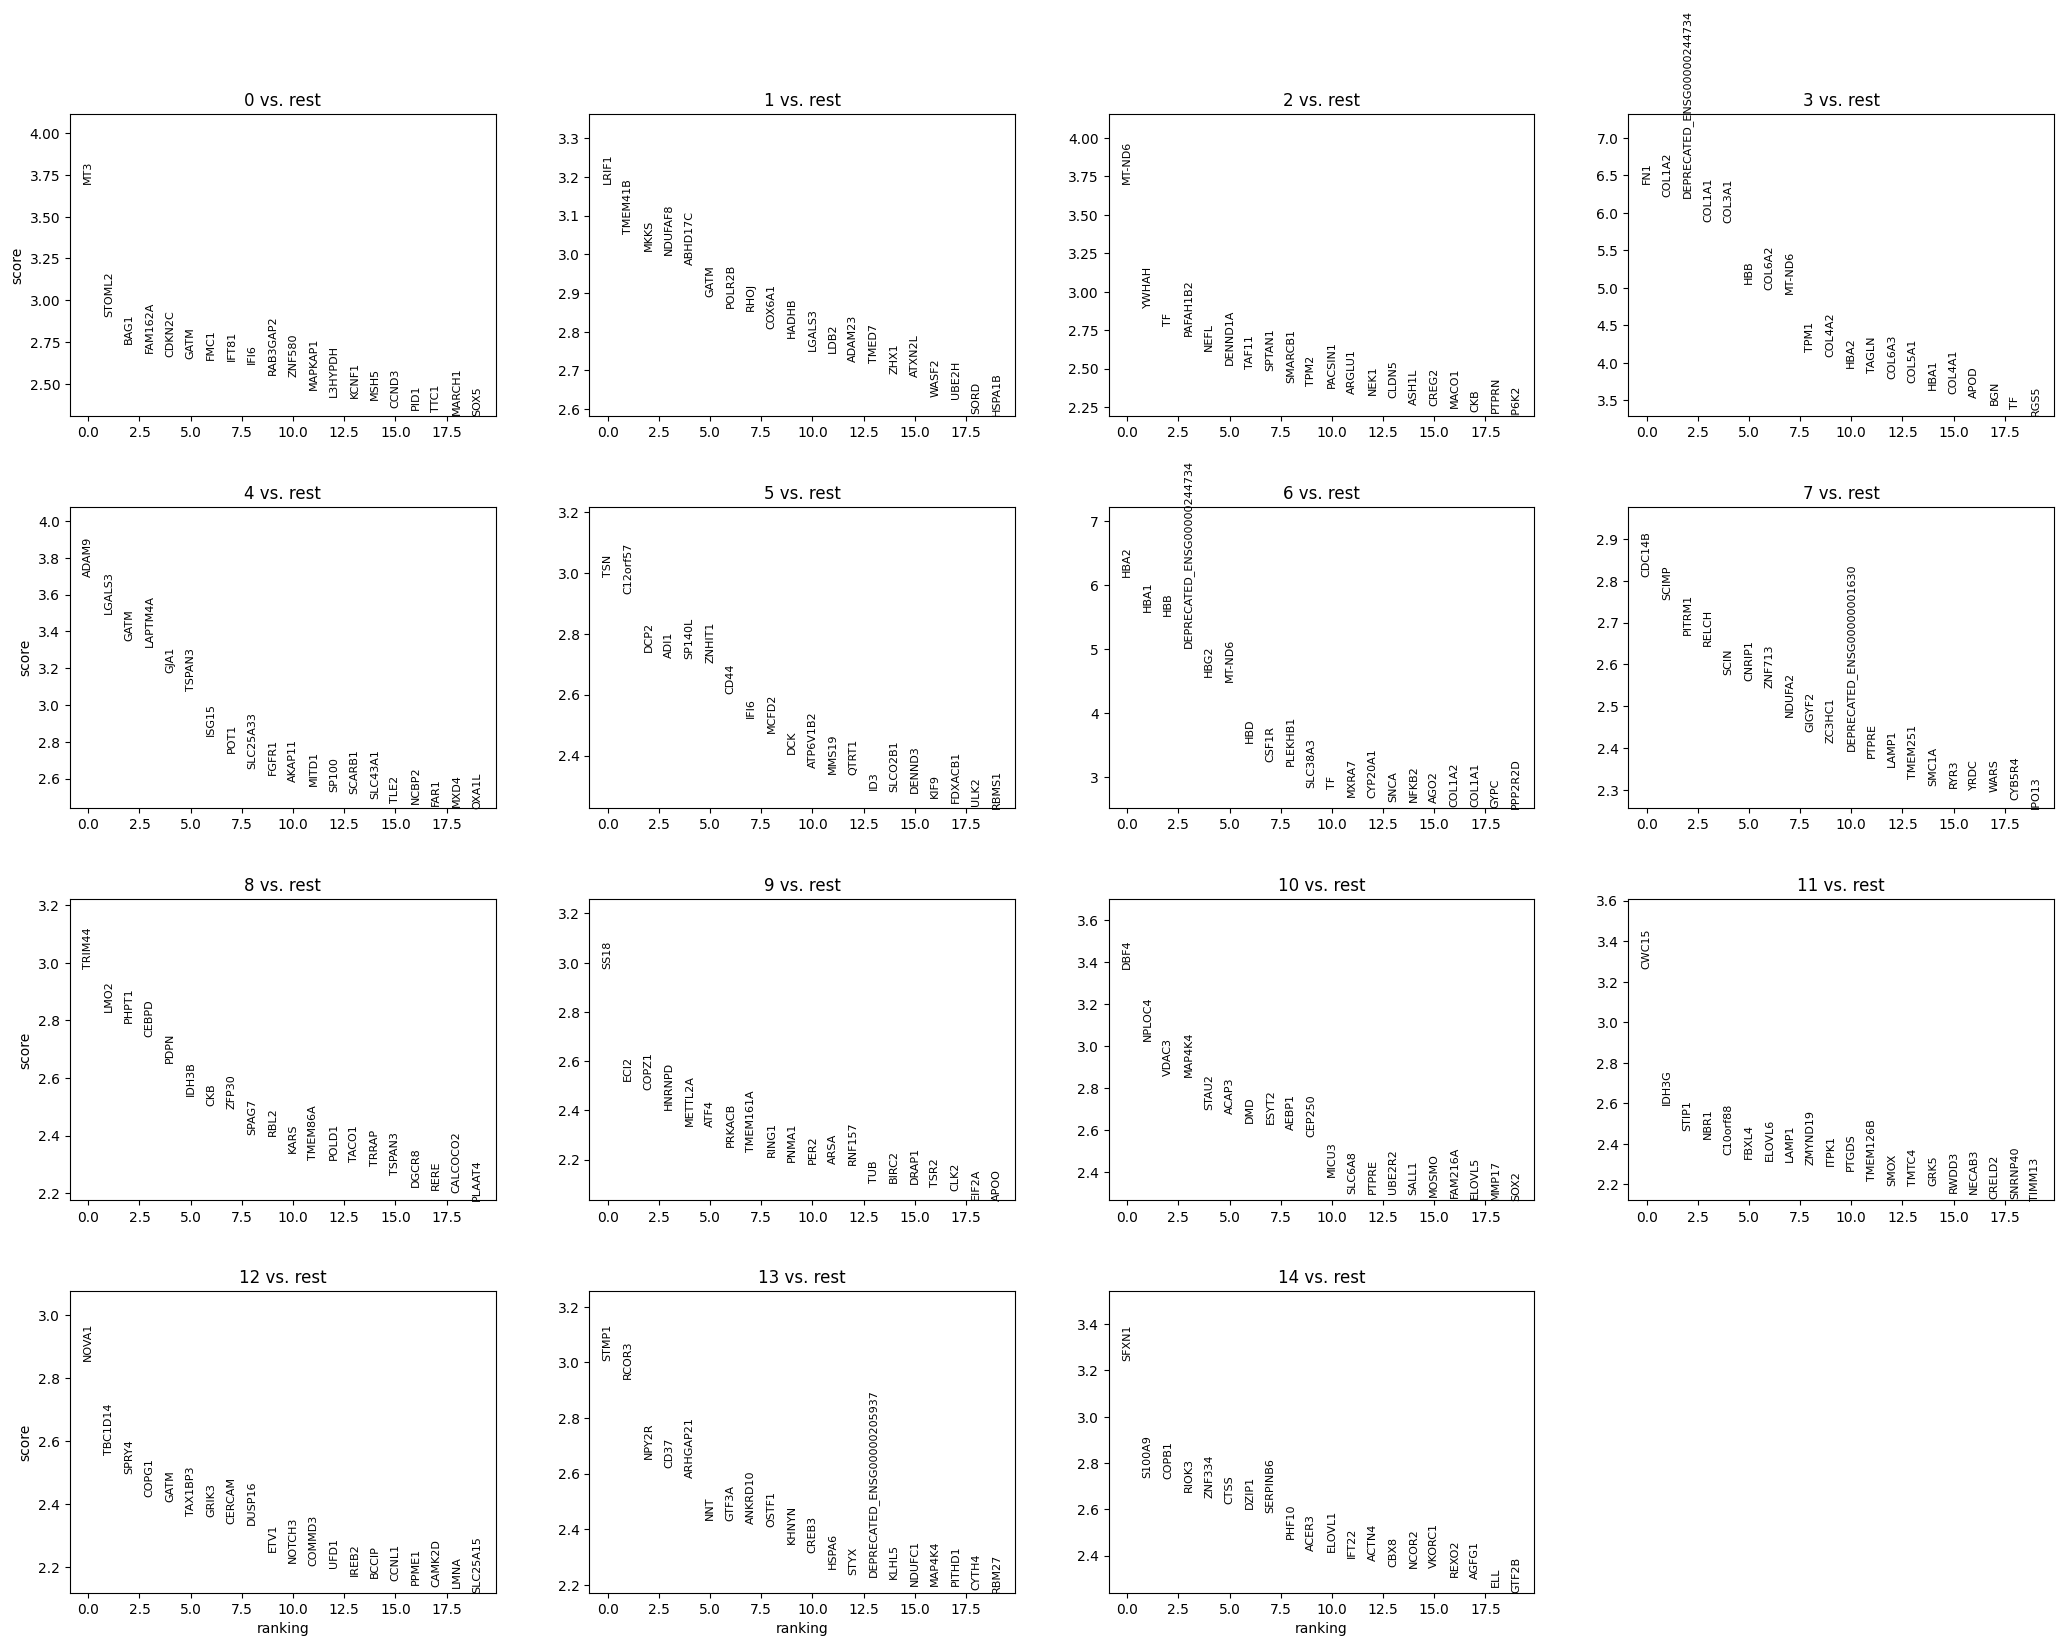

In [27]:

# Identify marker genes for each cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

# Plot marker genes
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/__init__.py:1303: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


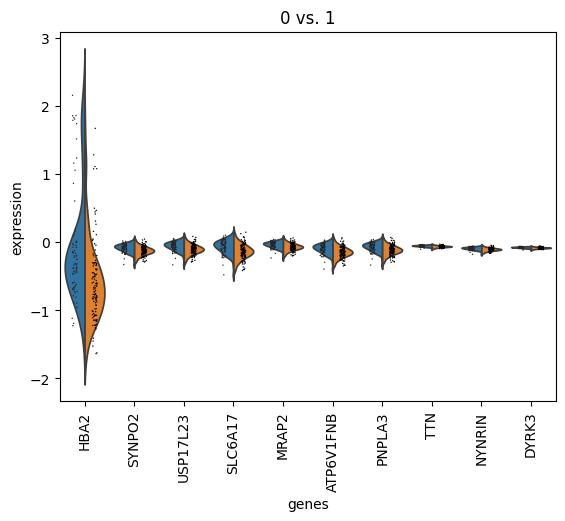

In [28]:


# Perform differential expression analysis between two clusters (e.g., cluster 0 and cluster 1)
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='t-test')

# Plot differentially expressed genes
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=10)


categories: 0, 1, 2, etc.
var_group_labels: 0


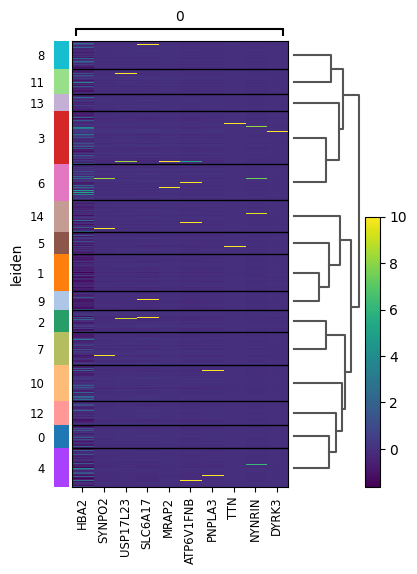

In [29]:


# Create a heatmap of marker genes
sc.pl.rank_genes_groups_heatmap(adata, n_genes=10, groupby='leiden')


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: 

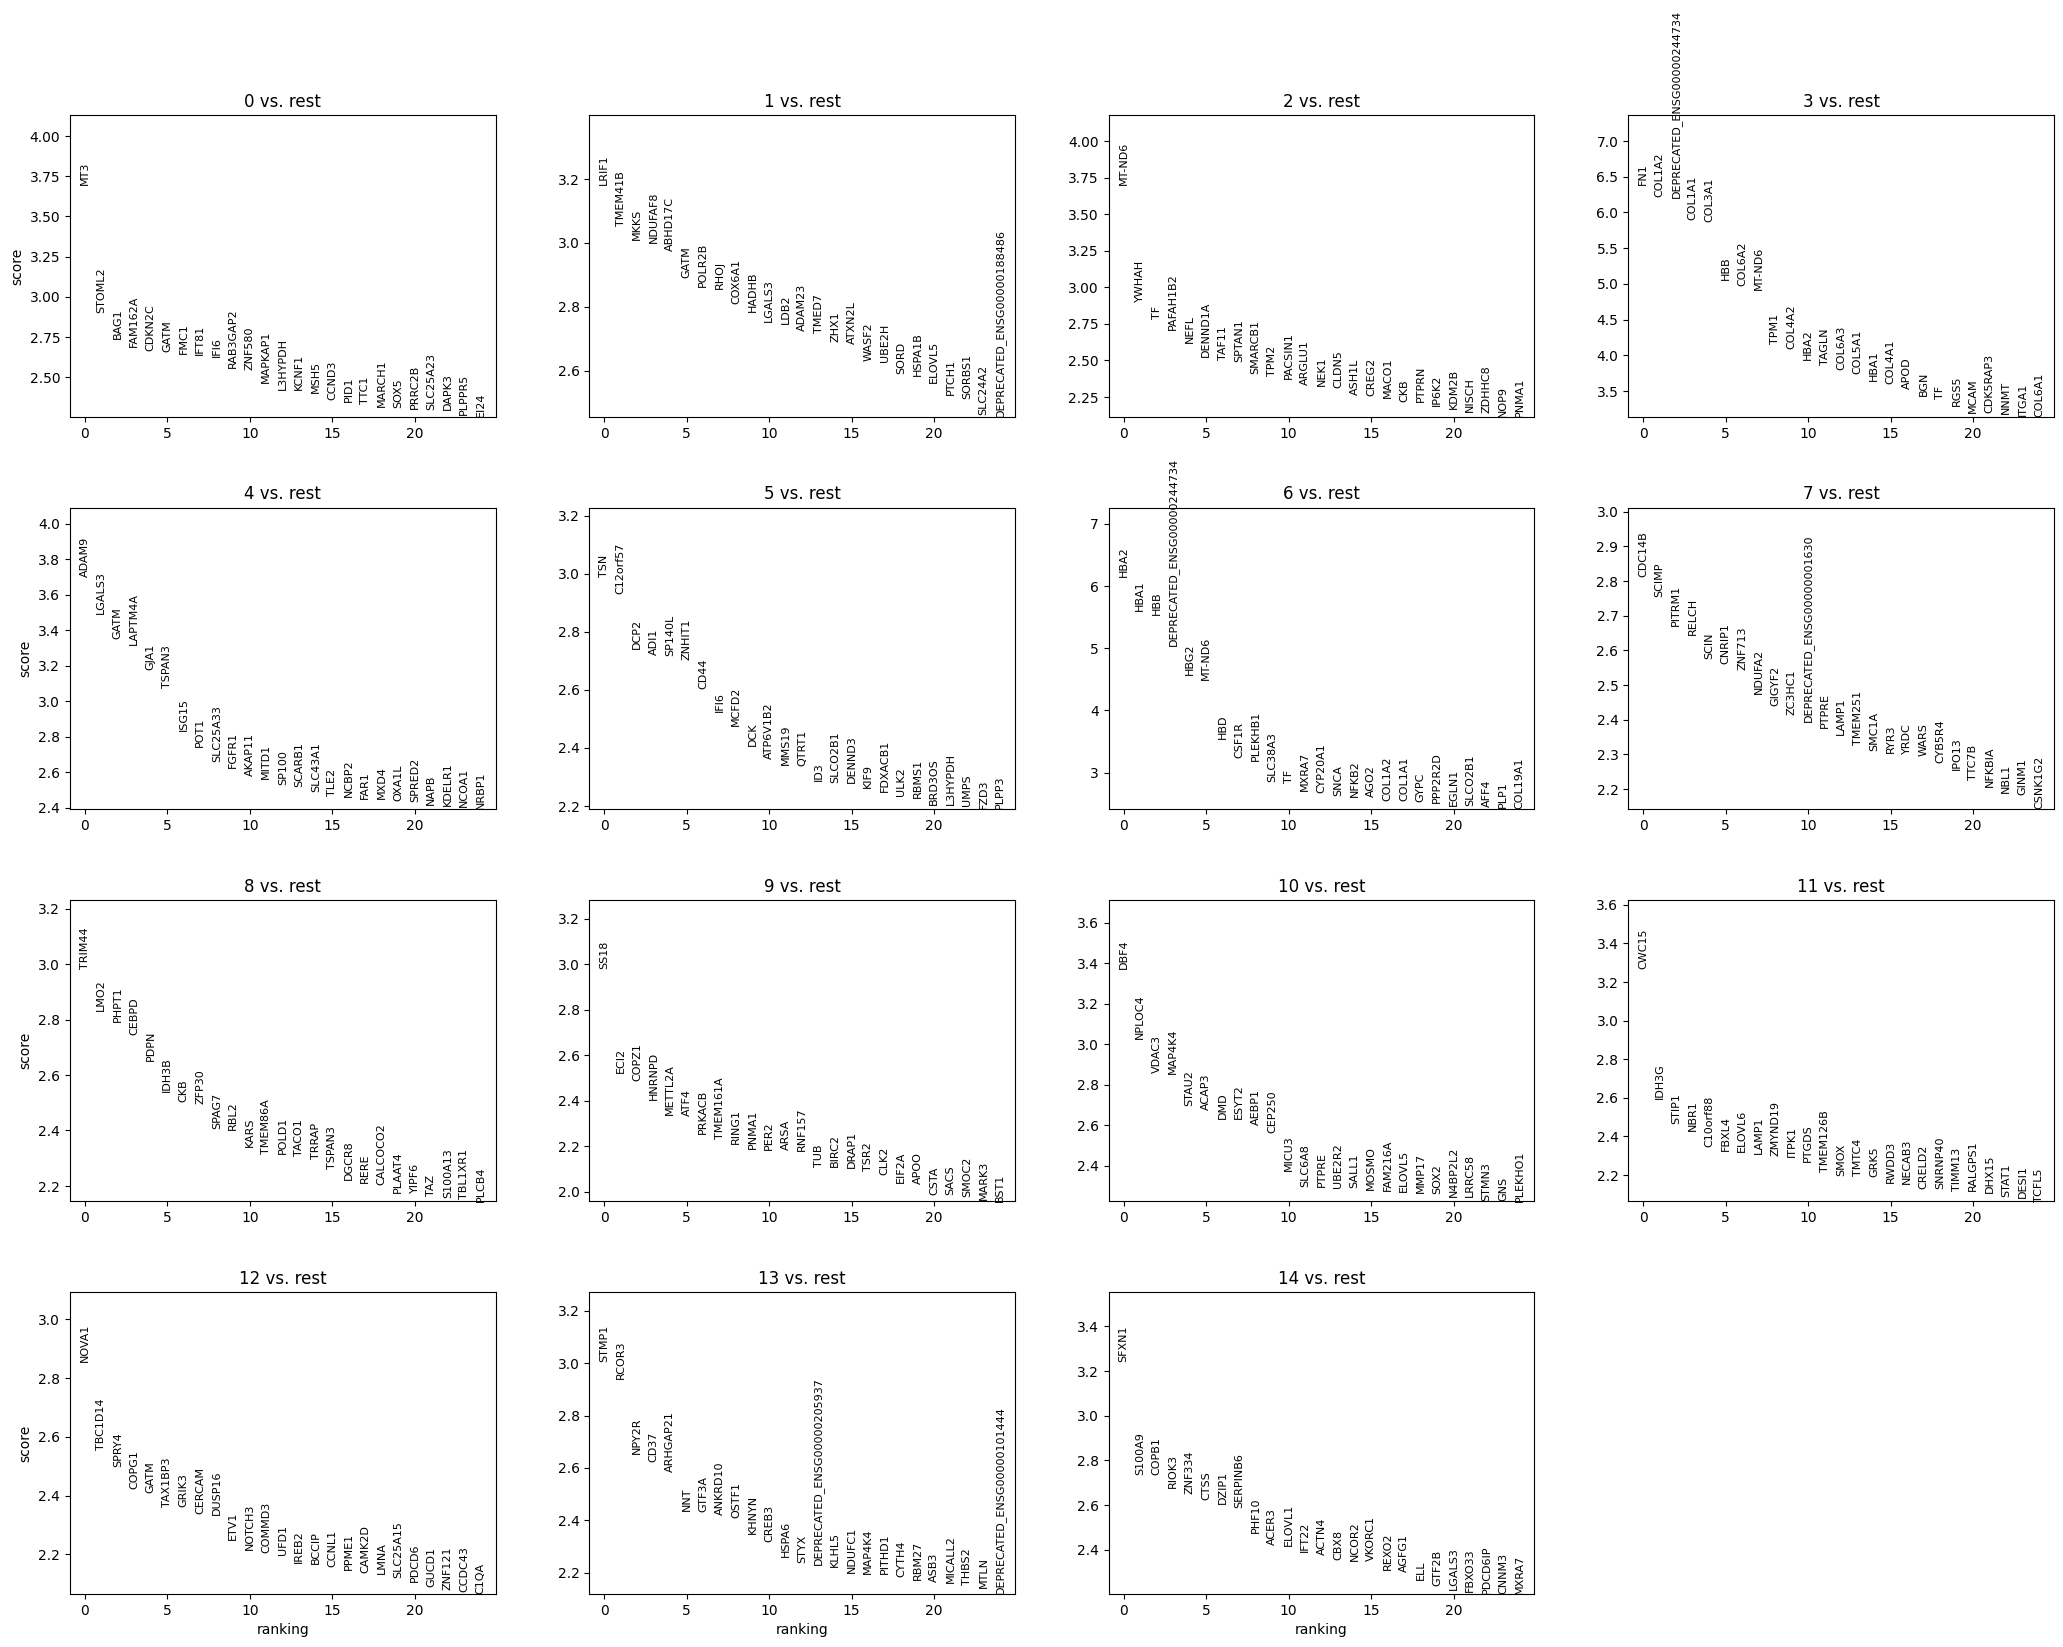

In [32]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='t-test')

# Plot the ranking of genes
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [33]:
adata

AnnData object with n_obs × n_vars = 1437 × 8719
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'pattern', 'read', 'secondary_name', 'sequence', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'tsne', 'rank_genes_groups', 'dendrogram_leiden'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


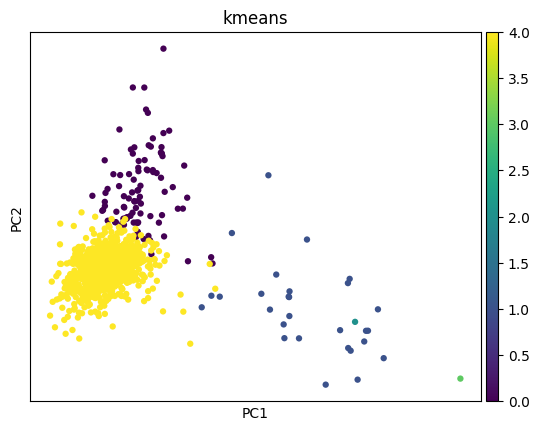

In [34]:

from sklearn.cluster import KMeans

# Initializing k-means
kmeans = KMeans(n_clusters=5, random_state=0)

# Run k-means
adata.obs['kmeans'] = kmeans.fit_predict(adata.obsm['X_pca'])


# Visual. the clusters
sc.pl.pca(adata, color='kmeans')


In [35]:
adata

AnnData object with n_obs × n_vars = 1437 × 8719
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'kmeans'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'pattern', 'read', 'secondary_name', 'sequence', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'tsne', 'rank_genes_groups', 'dendrogram_leiden'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

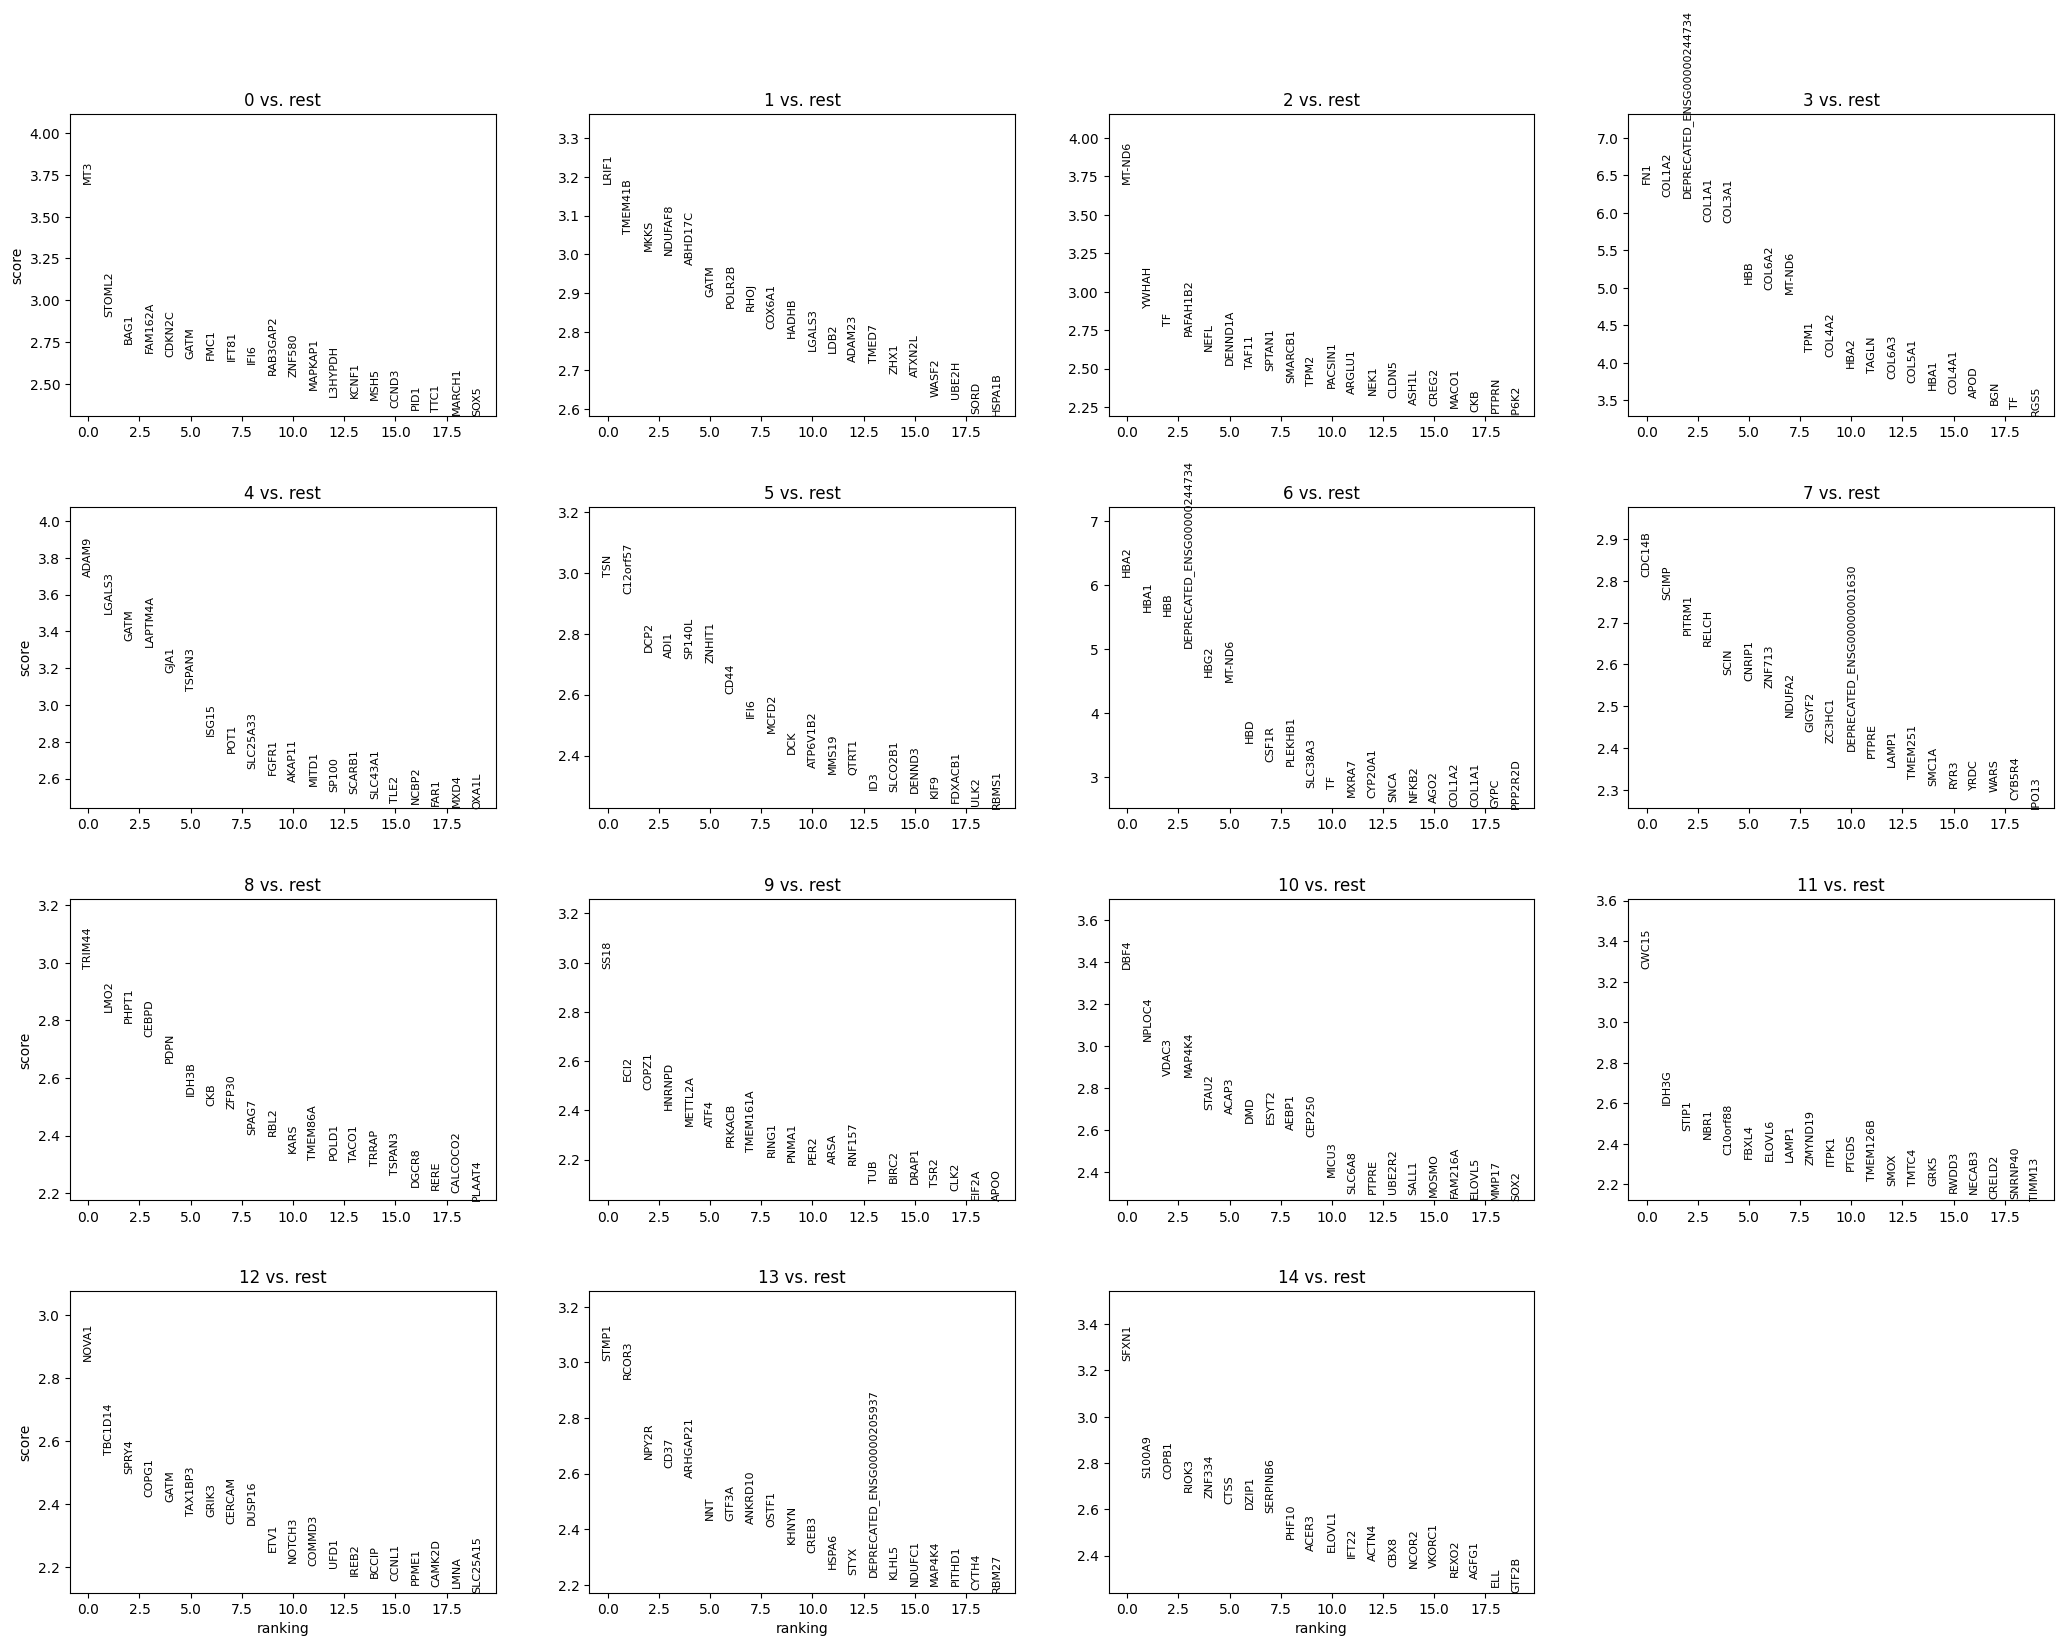

In [36]:
# Now, let's visualize the top 20 marker genes for each cluster
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

# To further understand the biological significance, we can perform functional enrichment analysis
# For this, we'll need to extract the marker genes
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
marker_genes = {group: [result['names'][group][i] for i in range(20)] for group in groups}

In [37]:
marker_genes

{'0': ['MT3',
  'STOML2',
  'BAG1',
  'FAM162A',
  'CDKN2C',
  'GATM',
  'FMC1',
  'IFT81',
  'IFI6',
  'RAB3GAP2',
  'ZNF580',
  'MAPKAP1',
  'L3HYPDH',
  'KCNF1',
  'MSH5',
  'CCND3',
  'PID1',
  'TTC1',
  'MARCH1',
  'SOX5'],
 '1': ['LRIF1',
  'TMEM41B',
  'MKKS',
  'NDUFAF8',
  'ABHD17C',
  'GATM',
  'POLR2B',
  'RHOJ',
  'COX6A1',
  'HADHB',
  'LGALS3',
  'LDB2',
  'ADAM23',
  'TMED7',
  'ZHX1',
  'ATXN2L',
  'WASF2',
  'UBE2H',
  'SORD',
  'HSPA1B'],
 '2': ['MT-ND6',
  'YWHAH',
  'TF',
  'PAFAH1B2',
  'NEFL',
  'DENND1A',
  'TAF11',
  'SPTAN1',
  'SMARCB1',
  'TPM2',
  'PACSIN1',
  'ARGLU1',
  'NEK1',
  'CLDN5',
  'ASH1L',
  'CREG2',
  'MACO1',
  'CKB',
  'PTPRN',
  'IP6K2'],
 '3': ['FN1',
  'COL1A2',
  'DEPRECATED_ENSG00000244734',
  'COL1A1',
  'COL3A1',
  'HBB',
  'COL6A2',
  'MT-ND6',
  'TPM1',
  'COL4A2',
  'HBA2',
  'TAGLN',
  'COL6A3',
  'COL5A1',
  'HBA1',
  'COL4A1',
  'APOD',
  'BGN',
  'TF',
  'RGS5'],
 '4': ['ADAM9',
  'LGALS3',
  'GATM',
  'LAPTM4A',
  'GJA1',
  'TSP

In [38]:
df_marker_genes = pd.DataFrame(marker_genes)

In [39]:
df_marker_genes

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,MT3,LRIF1,MT-ND6,FN1,ADAM9,TSN,HBA2,CDC14B,TRIM44,SS18,DBF4,CWC15,NOVA1,STMP1,SFXN1
1,STOML2,TMEM41B,YWHAH,COL1A2,LGALS3,C12orf57,HBA1,SCIMP,LMO2,ECI2,NPLOC4,IDH3G,TBC1D14,RCOR3,S100A9
2,BAG1,MKKS,TF,DEPRECATED_ENSG00000244734,GATM,DCP2,HBB,PITRM1,PHPT1,COPZ1,VDAC3,STIP1,SPRY4,NPY2R,COPB1
3,FAM162A,NDUFAF8,PAFAH1B2,COL1A1,LAPTM4A,ADI1,DEPRECATED_ENSG00000244734,RELCH,CEBPD,HNRNPD,MAP4K4,NBR1,COPG1,CD37,RIOK3
4,CDKN2C,ABHD17C,NEFL,COL3A1,GJA1,SP140L,HBG2,SCIN,PDPN,METTL2A,STAU2,C10orf88,GATM,ARHGAP21,ZNF334
5,GATM,GATM,DENND1A,HBB,TSPAN3,ZNHIT1,MT-ND6,CNRIP1,IDH3B,ATF4,ACAP3,FBXL4,TAX1BP3,NNT,CTSS
6,FMC1,POLR2B,TAF11,COL6A2,ISG15,CD44,HBD,ZNF713,CKB,PRKACB,DMD,ELOVL6,GRIK3,GTF3A,DZIP1
7,IFT81,RHOJ,SPTAN1,MT-ND6,POT1,IFI6,CSF1R,NDUFA2,ZFP30,TMEM161A,ESYT2,LAMP1,CERCAM,ANKRD10,SERPINB6
8,IFI6,COX6A1,SMARCB1,TPM1,SLC25A33,MCFD2,PLEKHB1,GIGYF2,SPAG7,RING1,AEBP1,ZMYND19,DUSP16,OSTF1,PHF10
9,RAB3GAP2,HADHB,TPM2,COL4A2,FGFR1,DCK,SLC38A3,ZC3HC1,RBL2,PNMA1,CEP250,ITPK1,ETV1,KHNYN,ACER3


In [44]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
anndata                          0.10.7
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_api_compat                 1.7.1
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.15.0
backcall                         0.2.0


**Enrichment**

In [48]:
import gprofiler as gp

marker_genes_list = df_marker_genes.values.tolist()

# Initializing  gProfiler
gp_api = gp.GProfiler(return_dataframe=True)


In [49]:

# enrichment analysis for each cluster
for i, genes in enumerate(marker_genes_list):
    # Removing any deprecated or unknown gene names before querying
    genes = [gene for gene in genes if not gene.startswith('DEPRECATED_')]

    # Query g:Profiler
    enrichment_results = gp_api.profile(organism='hsapiens', query=genes, sources=['GO:BP', 'KEGG', 'REAC'])

    # Saving the results for later
    enrichment_results.to_csv(f'cluster_{i}_enrichment_results.csv', index=False)

    # Print out the top 5 enriched terms for this cluster
    print(f'Cluster {i} - Top 5 Enriched Terms:')
    print(enrichment_results.head(5))


Cluster 0 - Top 5 Enriched Terms:
  source      native                 name  p_value  significant  \
0  GO:BP  GO:0042117  monocyte activation   0.0356         True   

                                         description  term_size  query_size  \
0  "The change in morphology and behavior of a mo...         12          14   

   intersection_size  effective_domain_size  precision    recall    query  \
0                  2                  21031   0.142857  0.166667  query_1   

        parents  
0  [GO:0002274]  
Cluster 1 - Top 5 Enriched Terms:
Empty DataFrame
Columns: [source, native, name, p_value, significant, description, term_size, query_size, intersection_size, effective_domain_size, precision, recall, query, parents]
Index: []
Cluster 2 - Top 5 Enriched Terms:
  source      native         name   p_value  significant  description  \
0   KEGG  KEGG:04216  Ferroptosis  0.034995         True  Ferroptosis   

   term_size  query_size  intersection_size  effective_domain_size  preci

**in-depth look at the top enriched terms for the clusters with significant results**

*Cluster 0* : Enriched in monocyte activation (GO:0042117), suggesting that the cells in this cluster may be involved in immune response and inflammation.

*Cluster 2* : Shows enrichment in ferroptosis (KEGG:04216), a form of programmed cell death that is dependent on iron and characterized by the accumulation of lipid peroxides.

*Cluster 5* : Indicates enrichment in the citric acid cycle (TCA cycle) (REAC:R-HSA-71403), which is central to cellular energy production.

*Cluster 7* : Highlighted for organelle organization (GO:0006996), which could imply a role in the assembly, arrangement of constituent parts, or disassembly of cellular structures.

*Cluster 12* :Enriched in arginine and proline metabolism (KEGG:00330), which are amino acids involved in various metabolic processes.

*Cluster 14* : Shows enrichment for chromatin modifying enzymes (REAC:R-HSA-3247509) and chromatin organization (REAC:R-HSA-4839726), suggesting a potential role in gene expression regulation.

*Cluster 15* : Enriched in the regulation of RUNX1 expression and activity (REAC:R-HSA-8934593), which is important in hematopoiesis.

*Cluster 19* : Enriched in inner mitochondrial membrane organization (GO:0007007), indicating a potential involvement in mitochondrial function and energy metabolism.

In [58]:
!pip install singler

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 90.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 101.0 MB/s eta 0:00:00
  Created wheel for assorthead: filename=assorthead-0.0.11-py3-none-any.whl size=1969095 sha256=3f748ec27e36b73a9847afb7e35cffcef75871e2f17d544882695195d435d178
  Stored in directory: /root/.cache/pip/wheels/2e/2b/a8/d688a64d7eb3711d4d20d2668e563f9e907fb503d6d3ca9a13
Successfully built assorthead


In [59]:
# Convert the expression matrix to a DataFrame
df_expression = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
df_marker_genes_transposed = df_marker_genes.transpose()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
import singler

# Run SingleR
singler_results = singler.annotate_single(
    df_expression,
    df_marker_genes_transposed,
    ref_data="BlueprintEncode",
    ref_features="symbol",
    ref_labels="main",
    cache_dir="_cache"
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'markers': {'Adipocytes': {'Adipocytes': [], 'Astrocytes': [], 'B-cells': [], 'CD4+ T-cells': [], 'CD8+ T-cells': [], 'Chondrocytes': [], 'DC': [], 'Endothelial cells': [], 'Eosinophils': [], 'Epithelial cells': [], 'Erythrocytes': [], 'Fibroblasts': [], 'HSC': [], 'Keratinocytes': [], 'Macrophages': [], 'Melanocytes': [], 'Mesangial cells': [], 'Monocytes': [], 'Myocytes': [], 'Neurons': [], 'Neutrophils': [], 'NK cells': [], 'Pericytes': [], 'Skeletal muscle': [], 'Smooth muscle': []}, 'Astrocytes': {'Adipocytes': [], 'Astrocytes': [], 'B-cells': [], 'CD4+ T-cells': [], 'CD8+ T-cells': [], 'Chondrocytes': [], 'DC': [], 'Endothelial cells': [], 'Eosinophils': [], 'Epithelial cells': [], 'Erythrocytes': [], 'Fibroblasts': [], 'HSC': [], 'Keratinocytes': [], 'Macrophages': [], 'Melanocytes': [], 'Mesangial cells': [], 'Monocytes': [], 'Myocytes': [], 'Neurons': [], 'Neutrophils': [], 'NK cells': [], 'Pericytes': [], 'Skeletal muscle': [], 'Smooth muscle': []}, 'B-cells': {'Adipocytes':

/usr/local/lib/python3.10/dist-packages/biocframe/BiocFrame.py:642: DeprecationWarning: Method 'column' is deprecated, use 'get_column' instead
  warn(
/usr/local/lib/python3.10/dist-packages/biocframe/BiocFrame.py:642: DeprecationWarning: Method 'column' is deprecated, use 'get_column' instead
  warn(


ValueError: number of rows of 'x' should be equal to the length of 'features'

In [65]:
df_expression = pd.DataFrame(adata.X.T, index=adata.var_names, columns=adata.obs_names)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
# Run SingleR using the 'annotate_single' function
singler_results = singler.annotate_single(
    test_data=df_expression,
    test_features=df_expression.index.tolist(),
    ref_data=df_marker_genes,
    ref_labels=df_marker_genes.columns.tolist(),
    ref_features=df_marker_genes.index.tolist(),
    cache_dir='_cache'
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NotImplementedError: tatamize is not supported for objects of class: <class 'pandas.core.frame.DataFrame'>